# Business Understanding

## Introduction
Traffic accidents are a critical public safety issue, causing injuries, fatalities and significant economic losses. Stakeholders such as traffic authorities and emergency services often face challenges in predicting and mitigating injury severity in crashes. Understanding the factors influencing injury outcomes can inform better policies, resource allocation and public safety to reduce injury severity and save lives.

## Use Cases
- Use the model to identify high-risk conditions (eg. weather, lighting, etc.) and implement measures like improved signage, speed limits or road design to reduce injury severity in traffic accidents.
- Predict the severity of injuries based on crash conditions, enabling emergency services to prioritize resources and respond more effectively to severe accidents. 

## Value Proposition
This project aims to develop a classification model that predicts injury severity in traffic crashes. By identifying key high-risk contributing to severe injuries, stakeholders can implement proactive measures to:
    - Reduce injury severity in traffic accidents through ad-hoc interventions
    - Enhance decision-making and resource allocation for emergency services
    - Improve public safety and save lives

# Business Objective
- The task is to predict the severity of injuries based on the given features:
    - Environment: The environment in which the accident occurred.
        - POSTED_SPEED_LIMIT: The posted speed limit.
        - WEAHTER_CONDITION: The weather condition.
        - LIGHTING_CONDITION: The lighting condition.
        - ROADWAY_SURFACE_COND: The roadway surface condition.
        - ROAD_DEFECT: Whether or not the road was defective.
        - TRAFFICWAY_TYPE: The type of trafficway.
        - TRAFFIC_CONTROL_DEVICE: The traffic control device present at the location of the accident.
    - Crash Dynamics: The dynamics of the crash.
        - FIRST_CRASH_TYPE: The type of the first crash.
        - TRAFFICWAY_TYPE: The type of trafficway.
        - ALIGNMENT: The alignment of the road.
        - LANE_CNT: The number of through lanes in either direction.
        - CRASH_HOUR: The hour of the crash.
        - CRASH_DAY_OF_WEEK: The day of the week of the crash.
        - CRASH_MONTH: The month of the crash.
    - Human Factors:
        - PRIM_CONTRIBUTORY_CAUSE: The primary contributory cause of the accident.
        - SEC_CONTRIBUTORY_CAUSE: The secondary contributory cause of the accident.
        - HIT_AND_RUN_I: Whether or not the crash involved a hit and run.
        - NOT_RIGHT_OF_WAY_I: Whether or not the crash involved a violation of the right of way.
        - WORK_ZONE_I: Whether or not the crash occurred in a work zone.
    - Location Factors:
        - LATITUDE: The latitude of the location of the crash.
        - LONGITUDE: The longitude of the location of the crash.
        - BEAT_OF_OCCURRENCE: The police beat of occurrence.
    - Target:
        - MOST_SEVERE_INJURY: Multi-class classification target (eg. FATAL, INCAPACITATING INJURY, NONINCAPACITATING INJURY, REPORTED, NO INJURY).


# Data Understanding

## Introduction
The dataset contains information about traffic accidents in Chicago. Stakeholders need reliable data-driven insights to mitigate injury severity and optimize their strategies. The dataset in this project is directly related to the task of predicting injury severity in traffic accidents.

## Data Description
- The dataset includes detailed records of traffic accidents covering various features such as environment, crash dynamics, human factors, location factors and target variable MOST_SEVERE_INJURY.

## Data Quality
- The dataset is very large with over 400,000 records and 49 features, providing a rich source of information for analysis.
- The dataset comes from the City of Chicago's [open data portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) and is updated daily making it a reliable source of information for stakeholders.

## Data Relevance
- Use data on crash conditions (eg. weather) to identify high-risk conditions take proative measures.
- Predict injury severity to prioritize emergency services and allocate resources more effectively. 

## Conclusion
The dataset is robust, relevant and continually updated, making it an indispensable resource for the task of predicting injury severity in traffic accidents. 

# Data Preparation

## Assembly
- The source data is comprised of three CSV files:
    - [Crash Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data)
    - [Driver/Passenger Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data)
    - [Vehicles Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/about_data)
- The data will be assembled into a single dataset by joining the three tables on the common key CRASH_RECORD_ID.

## Cleaning
- Irrelevant columns that do not contribute to the task will be dropped.
- Missing values that will be imputed or dropped.

## Transformation
- Categorical features will be encoded using one-hot encoding.
- Numerical features will be scaled using standard scaling.

## Splitting
- The dataset will be split into training and testing sets using a standard 80/20 split.
- These sets will be saved to disk for future use as:
    - [X_train](./data/X_train.csv)
    - [X_test](./data/X_test.csv)
    - [y_train](./data/y_train.csv)
    - [y_test](./data/y_test.csv)

# Modeling

## Import Libraries

In [41]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



## Load Data

In [42]:
# load data
import pandas as pd
data = pd.read_csv('./data/Traffic_Crashes_-_Crashes_20250122.csv')
# data_vehicles = pd.read_csv('./data/Traffic_Crashes_-_Vehicles_20250122.csv')
# data_people = pd.read_csv('./data/Traffic_Crashes_-_People_20250122.csv')

## Data Preprocessing
- Handle missing values using imputation or dropping.
- Drop columns with a high rate (> 50%) missing values.

In [43]:
# calculate null percentages
null_percentage = data.isnull().mean() * 100

# drop columns with more than 50% missing values
columns_to_drop = null_percentage[null_percentage > 50].index
data = data.drop(columns=columns_to_drop)

### Imputing Missing Values
- Numerical features missing values will be imputed using the median.
- Categorical features missing values will be imputed using the mode.

In [44]:
# fill categorical columns with mode
for column in data.select_dtypes(include='object').columns:
    mode_value = data[column].mode()[0]
    data[column] = data[column].fillna(mode_value)

# fill numerical columns with median
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)

## Feature Analysis & Selection

### Feature Selection for Categorical Features

In [45]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
encoder = LabelEncoder()
categorical_features = data.select_dtypes(include='object').columns
data_encoded = data[categorical_features].apply(encoder.fit_transform)

# chi-square test
chi_scores, p_values = chi2(data_encoded, LabelEncoder().fit_transform(data['MOST_SEVERE_INJURY']))
chi2_results = pd.DataFrame({'Feature': categorical_features, 'Chi2 Score': chi_scores, 'P-Value': p_values})

# select the most relevant features (p-value < 0.05)
categorical_features = chi2_results[chi2_results['P-Value'] < 0.005]['Feature'].values

### Feature Selection for Numerical Features

In [46]:
# feature selection using ANOVA for numerical features
from sklearn.feature_selection import f_classif

numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
f_scores, p_values = f_classif(data[numerical_features], data['MOST_SEVERE_INJURY'].factorize()[0])

anova_results = pd.DataFrame({'Feature': numerical_features, 'F-Score': f_scores, 'P-Value': p_values})

# select the most relevant features (p-value < 0.005)
numerical_features = anova_results[anova_results['P-Value'] < 0.005]['Feature'].values

# merge selected features
features = np.concatenate([categorical_features, numerical_features])

/Users/rob/micromamba/envs/learn-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/rob/micromamba/envs/learn-env/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Select Relevant Features & Remove Duplicates
- Remove features that are not relevant to the task.
- Remove duplicate records.

In [47]:
# select relevant features
data = data[features]

# drop redundant columns
data = data.loc[:, ~data.columns.duplicated()]

# drop duplicates in rows (optional)
data = data.drop_duplicates()

## TODO :: Correlation Matrix
- Create a correlation matrix to identify relationships between features and the target variable.
- Ensure that multicollinearity is not present in the dataset.

## Variance Threshold for Feature Selection
- Use the variance threshold to remove features with low variance.

# Baseline Model
- Encode the target variable using label encoding.
- Split the data into training and testing sets.

In [48]:
# encode the target variable
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['MOST_SEVERE_INJURY'] = label_encoder.fit_transform(data['MOST_SEVERE_INJURY'])

In [49]:
# encode categorical variables 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=True, drop='first')
X_categorical = encoder.fit_transform(data[categorical_features])

## takes a long time to run
# data = pd.get_dummies(data, columns=data.select_dtypes(include='object').columns, drop_first=True)

In [50]:
# standardize numerical features
from sklearn.preprocessing import StandardScaler

# select numerical columns
numerical_columns = data[numerical_features].columns

# scale numerical columns
scaler = StandardScaler()
X_numerical = scaler.fit_transform(data[numerical_columns])

In [53]:
from scipy.sparse import hstack

# use hstack to combine the sparse matrix and the dense matrix
X = hstack([X_numerical, X_categorical])

# target variable
y = data['MOST_SEVERE_INJURY']

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
    )

In [ ]:
# use SMOTE to balance the target variable
from imblearn.over_sampling import SMOTE

# apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

MOST_SEVERE_INJURY
2    548424
3    548424
4    548424
1    548424
0    548424
Name: count, dtype: int64

In [70]:
# train logistic regression model
baseline_model = LogisticRegression(
    max_iter=100, 
    random_state=42,
    )
baseline_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [71]:
# evaluate model
y_pred = baseline_model.predict(X_test)

In [72]:
# create classification report and format it as a DataFrame
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,298.0
1,1.0,1.0,1.0,4554.0
2,1.0,1.0,1.0,235040.0
3,1.0,1.0,1.0,21598.0
4,1.0,1.0,1.0,12018.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,273508.0
weighted avg,1.0,1.0,1.0,273508.0


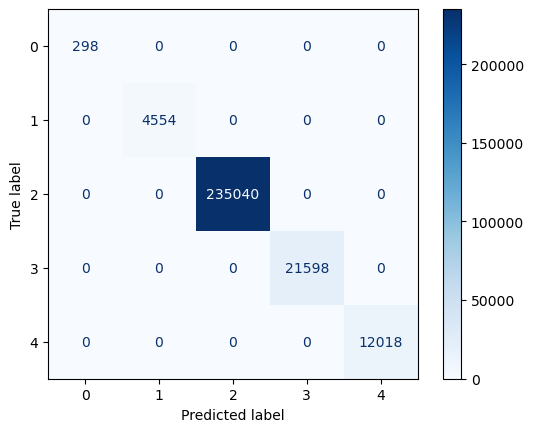

In [73]:
# create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=baseline_model.classes_)
disp.plot(cmap='Blues')

In [58]:
# perform cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.94373105 0.94474956 0.94343333 0.94321351 0.94468645]
Mean accuracy: 0.9439627817951936


In [65]:
# calculate ROC curve
y_pred_proba = baseline_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


ValueError: multiclass format is not supported

## Baseline Model Results
- The model is performing too well on the training set, indicating overfitting.

## Baseline Model Round 2
- Use stratified sampling to ensure that the training and testing sets have the same distribution of the target variable.
- Use ridge penalty to reduce overfitting.
- Adjust the hyperparameters to improve the model's performance.